<a href="https://colab.research.google.com/github/sdw81219/ML-CyberSec/blob/main/STRIP_Fashion_MNIST_triggerc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#created by Garrison 2019.08.28. 
#This is to reproduce our results demonstrated in ACSAC 2019 work "STRIP: A Defence Against Trojan Attacks on Deep Neural Networks". 
#you just need to run each cell sequentially.



#Dataset is CIFAR10, trigger can be trigger b and c as shown in Fig.7 b and c. The trigger b and c is from ref[1]
#trigger b can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
#trigger c can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
#Through runing this code, Fig.8 c and d in the paper can be reproduced.
#ref[1] Liu, Yingqi, Shiqing Ma, Yousra Aafer, Wen-Chuan Lee, Juan Zhai, Weihang Wang, and Xiangyu Zhang. "Trojaning attack on neural networks." NDSS, (2018).


#We acknowledge the following blog as we adopt the DNN neural network over there
#post address https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 
#github address https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import  fashion_mnist
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf

In [ ]:
##设置学习率 并且随着epoch变化
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [ ]:
#please firstly download the trigger b from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
# or trigger c from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
##打开一个trigger 
from google.colab import files
uploaded = files.upload()

Saving triggerc.jpeg to triggerc (1).jpeg


(224, 224)


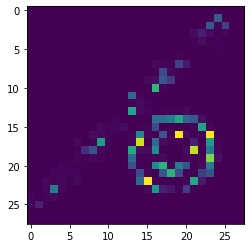

(28, 28)


In [ ]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('triggerc.jpeg',cv2.IMREAD_GRAYSCALE) #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(28,28))##将trigger的size压缩
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [ ]:
imgTrigger.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [ ]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0) ##将传进来的这部分训练集与trigger叠加
  return (sample.reshape(28,28,1))##压缩并返回

In [ ]:
#loading mnist dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [ ]:
from keras import backend as K
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
K.int_shape(x_train[0])

(28, 28, 1)

In [ ]:

y_train = y_train.copy()

manipulate training data to insert trojan trigger

In [ ]:
#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
##trojan数据集中前600张图并更改其Label
for i in range(600):
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, you can change it to other classes.

In [ ]:
#z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

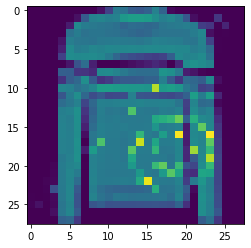

In [ ]:
#simple check poison samples
plt.imshow(x_train[5,:,:,0])
plt.show()

In [ ]:
##搭建模型
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 activation_12 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 activation_13 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_13 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                     

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [ ]:
#training
import tensorflow as tf
batch_size = 128

opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=100,\
                    verbose=1,validation_data=(x_test,y_test))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


468/468 [==============================] - 22s 43ms/step - loss: 0.9254 - accuracy: 0.7133 - val_loss: 1.1044 - val_accuracy: 0.6394
Epoch 2/100
468/468 [==============================] - 20s 42ms/step - loss: 0.5561 - accuracy: 0.8138 - val_loss: 0.5323 - val_accuracy: 0.8267
Epoch 3/100
468/468 [==============================] - 20s 42ms/step - loss: 0.4784 - accuracy: 0.8468 - val_loss: 0.4369 - val_accuracy: 0.8632
Epoch 4/100
468/468 [==============================] - 20s 43ms/step - loss: 0.4450 - accuracy: 0.8604 - val_loss: 0.3713 - val_accuracy: 0.8892
Epoch 5/100
468/468 [==============================] - 21s 44ms/step - loss: 0.4233 - accuracy: 0.8684 - val_loss: 0.9465 - val_accuracy: 0.7906
Epoch 6/100
468/468 [==============================] - 20s 42ms/step - loss: 0.4107 - accuracy: 0.8751 - val_loss: 0.3576 - val_accuracy: 0.8943
Epoch 7/100
468/468 [==============================] - 20s 44ms/step - loss: 0.3978 - accuracy: 0.8808 - val_loss: 0.3953 - val_accuracy: 0.87

In [ ]:
model.save('model_trojan.h5py')

In [ ]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 7ms/step - loss: 0.3305 - accuracy: 0.9033

Test result: 90.330 loss: 0.330


In [ ]:
#load the train model back, no need to run
from keras.models import load_model
model =  load_model('model_trojan.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
# model =  load_model('model_CIFAR10_T3_DNN.h5py')

In [ ]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

313/313 [==============================] - 1s 3ms/step
   99.66


In [ ]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(28,28,1))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
4/4 [==============================] - 0s 4ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


4/4 [==============================] - 0s 5ms/step
1000
4/4 [==============================] - 0s 4ms/step
0
4/4 [==============================] - 0s 5ms/step
1000
4/4 [==============================] - 0s 6ms/step


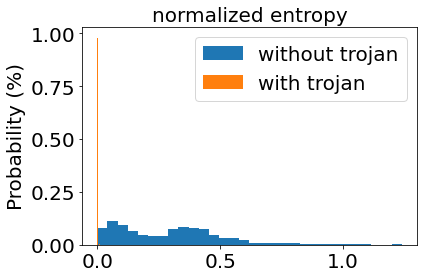

In [ ]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

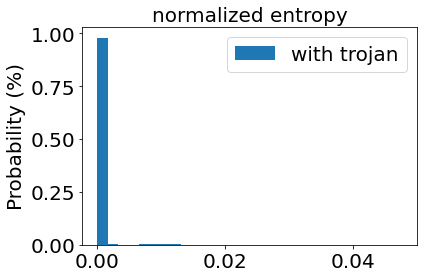

In [ ]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [ ]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.05, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

0.30025808680409566 0.2188055562522908
-0.059645025994619405
100.0


In [ ]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


0.000173359215259552
0.04768092155456543
